## FlipExpander.py

In [5]:
import numpy as np             
import matplotlib.pyplot as plt
import h5py

In [7]:
fname = 'ETM08'
dataset= h5py.File(f'{fname}.h5','r')

xIn= np.array(dataset['x'])
yIn= np.array(dataset['y'])
# saving the opd matrix
mapIn = dataset['A'][()]

In [8]:
def flip_expander(mapIn,xIn, yIn, r0,rOut):
    '''
    mapIn: 2d matrix with opd values
    xIn,yIn: 1d array with cartesian coordinates of the mirror
    r0: number, a choosen radius inside the real mirror radius, from which we'll flip the data
    rOut: number, desired extended radius
    
    return: mapOut,xOut,yOut
    '''
   

    def new_coordinates(xIn,rOut):
        '''
        This function compute the new cartesian coordiantes for xOut and yOut
        using an adjusted version of rOut to fit the step size an integer number of times. 
        ------
        dx = float,step size
        xIn = 1darray with initial cartesian coordinates
        rOut= float, desired extended radius
        '''
        #define step size
        dx = xIn[1]-xIn[0]
        # gap between rOut and the real mirror radius (given by the max value in xIn)
        gap = rOut - np.max(xIn) 
        print(gap)
        # (gap / step size) gives how many points of a stepsize length fit inside the gap
        n_point_gap = np.ceil(gap/dx)  # round number of points for eccess
        print(n_point_gap)
        # converting the gap number of points in meters
        conv_gap = n_point_gap*dx # how large is the gap in meters
        print(conv_gap)
        # adjusted radius tailored on the step size 
        rOut_x = abs(np.max(xIn) +conv_gap)
        print(rOut_x)
        # new xaxis for the extended map
        xOut = np.arange(-rOut_x,rOut_x,dx)
        # same for yOut

        return dx,xOut
    
    # computing th cartisian coordinates
    dx,xOut = new_coordinates(xIn,rOut)
    dy,yOut = new_coordinates(yIn,rOut)
    
    ####### silver line
    
    # mask
    mapOut = np.full((yOut.size, xOut.size), np.nan)
    # matrix of cartisian coordinates for mapOut
    X,Y = np.meshgrid(xOut,yOut)
    R_var2 = X**2+Y**2
    R_var = np.sqrt(R_var2)
    # same for mapIn
    x_,y_ = np.meshgrid(xIn,yIn)
    r_var = np.sqrt(x_**2+y_**2)
    # we place mapIn in the middle of mapOut, it's an equivalent to use np.where()
    mapOut[R_var<=r0]=mapIn[r_var<=r0]
    
    ####### silver line
    
    # we compute now the reversed radius in the big donut r0 < r <=rOut
    # we do it one for the small donut r0 < r <= 3*r0, 
    # we do it twice for he values in 3*r0 < r<= rOut
    
    # index for the big donut
    ind = (R_var>r0) & (R_var<=rOut)
    # reversed radius
    rrev = abs(2*r0 - R_var[ind]**2)
    # if R_var>3*r0 then reverse the radius twice, so to have a rrev value as 
    for i,j in enumerate(rrev):
        if j>3*r0:
            rrev[i]== 2*r0 - j
    # polar coordinates for all the values in the big donuts
    theta = np.arctan2(Y[ind], X[ind])
    # now we have a donuts full of cartesian coordinates, we have to replace them with the corrisponding cartisian coordinate value in mapIn and fill mapOut with it
    # this are indices
    
    rows_mapIn, cols_mapIn = mapIn.shape
    
    xgrev = np.floor(rrev * np.cos(theta) / dx + cols_mapIn / 2 + 0.5).astype(int)
    ygrev = np.floor(rrev * np.sin(theta) / dy + rows_mapIn / 2 + 0.5).astype(int)
    
    for n in range(len(ind)):
        id = ind[n]
        mapOut[id] = mapIn[ygrev[n], xgrev[n]] 
        
    return mapOut,xOut,yOut
  

0.010000000000000009
25.0
0.010012515644555742
0.17001251564455575
0.010000000000000009
25.0
0.010025062656641298
0.1700250626566413


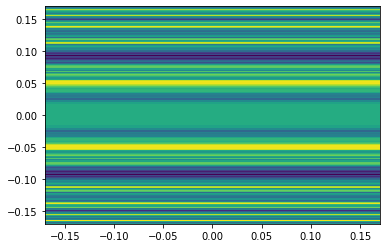

In [9]:
mapOut,xOut,yOut = flip_expander(mapIn,xIn,yIn,0.15,0.17)

plt.pcolormesh(xOut,yOut,mapOut)